# 以下テンプレート

In [1]:
# 表示用
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook

In [2]:
import numpy as np
import datetime
import os
import copy

# Parametor about Sensor
SensorNum=1 # Sensor number
#SensorAxis='AccX' # Axis

# Define Data Name
DATE= str( datetime.date.today() )+'/'
TITLE="Participants01_First_1/"
Label = ['LeftHand','RightHand','LeftLeg','Rightleg','West','Chest']

# Parametor about " Data Path"
DataPath = "/media/takeyama/Transfer/02_ActivityResearch/Paticipants01/01_First/20161018-105301/mem/"
StorePath = "/media/takeyama/Transfer/02_ActivityResearch/"

if not os.path.exists(StorePath+TITLE+'dictionary/'): 
    os.makedirs(StorePath+TITLE+'dictionary/')
DictionaryDataPath=StorePath+TITLE+'dictionary/'

if not os.path.exists(StorePath+TITLE+'window/'): 
    os.makedirs(StorePath+TITLE+'window/')
WindowDataPath=StorePath+TITLE+'window/'

if not os.path.exists(StorePath+TITLE+DATE+'studyOutput/'): 
    os.makedirs(StorePath+TITLE+DATE+'studyOutput/')
StudyOutputPath=StorePath+TITLE+DATE+'studyOutput/'

if not os.path.exists(StorePath+TITLE+DATE+'parametor/'): 
    os.makedirs(StorePath+TITLE+DATE+'parametor/')
ParametorPath=StorePath+TITLE+DATE+'parametor/'

if not os.path.exists(StorePath+TITLE+DATE+'result/'): 
    os.makedirs(StorePath+TITLE+DATE+'result/')
ResultPath=StorePath+TITLE+DATE+'result/'

if not os.path.exists(StorePath+TITLE+DATE+'graph/'): 
    os.makedirs(StorePath+TITLE+DATE+'graph/')
GraphPath=StorePath+TITLE+DATE+'graph/'

**センサデータの読み込み**

In [3]:
# センサデータのcsvファイル名をリストに集約する関数
def SensorDataFileNameList(path):
    l = os.listdir(DataPath)
    FilePath =[]
    SensorName = []
    
    for n in range(len(l)):
        if (l[n][:4].find('mem-') != -1):
            FilePath.append(l[n])
            SensorName.append(l[n][4:15])
    
    return FilePath,SensorName

CSVを読み込んで，CSVの中身を辞書型で表現する．

In [4]:
def ImportCSV(csv_file,SensorName,mode='Round'):
    import pandas as pd
    '''
    ~Argument~
    csv_file -> ファイル名 
    mode Round -> 四捨五入
         Roundup -> 切り上げ
         Rounddown -> 切り捨て
    
    ~Conversion~
    Acc Data  [0.1mG]=>[G]
    Gyr Data  [0.01dps]=>[dps]   ...dps=degree per second
    '''
    # data dictionary 
    RawData={}   
    AccConversion = 0.1 * 0.001
    GyrConversion = 0.01
    
    # design dataframe and import csv
    data = pd.read_csv(csv_file)
    data.columns=[u'Type',u'Time',u'AccX',u'AccY',u'AccZ',u'GyrX',u'GyrY',u'GyrZ']
    data = data[ data['Type']=='ags']

    # convert numpy.darray 

    AccX=data.AccX.values*AccConversion
    AccY=data.AccY.values*AccConversion
    AccZ=data.AccZ.values*AccConversion
    
    GyrX=data.GyrX.values*GyrConversion
    GyrY=data.GyrY.values*GyrConversion
    GyrZ=data.GyrZ.values*GyrConversion

    # regist each raw data 
    RawData['AccX'] = AccX
    RawData['AccY'] = AccY
    RawData['AccZ'] = AccZ
    RawData['GyrX'] = GyrX
    RawData['GyrY'] = GyrY
    RawData['GyrZ'] = GyrZ
    RawData['Name'] = SensorName

    RawData['Time'] = data.Time.values

    return RawData

In [5]:
# FFT library
from scipy import fftpack
from scipy import signal

# Graph Plot
import matplotlib.pyplot as plt

# Generate WindowFrame Function
from mymodule import window

# timer
import time

%matplotlib inline

In [6]:
from keras.models import Sequential
from keras.datasets import cifar10
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import SGD, Adadelta, Adagrad, Adam, Adamax, RMSprop, Nadam
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils.visualize_util import model_to_dot, plot
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping

import matplotlib.image as mpimg


Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5005)


**Phase1 計測データの取得**

ここで行うことは，学習に用いるnpzファイルを読み込む

In [7]:
print DictionaryDataPath

/media/takeyama/Transfer/02_ActivityResearch/Participants01_First_1/dictionary/


In [8]:
DictName=os.listdir(DictionaryDataPath)
print DictName

['Chest.npz', 'LeftHand.npz', 'LeftLeg.npz', 'RightHand.npz', 'Rightleg.npz', 'West.npz']


In [9]:
Sensor1 = np.load(DictionaryDataPath+DictName[0])['data'][()]
Sensor2 = np.load(DictionaryDataPath+DictName[1])['data'][()]
Sensor3 = np.load(DictionaryDataPath+DictName[2])['data'][()]
Sensor4 = np.load(DictionaryDataPath+DictName[3])['data'][()]
Sensor5 = np.load(DictionaryDataPath+DictName[4])['data'][()]
Sensor6 = np.load(DictionaryDataPath+DictName[5])['data'][()]

**Phase2 window flame 作成 & Learning**

In [10]:
def AutoEncoder(TrainWindow,TestWindow,dim,opt,cname,batchSize):
    """
    TrainWindow: 訓練データ
    TestWindow: テストデータ
    dim: 中間層の次元数
    opt: 最適化関数
    cname: 各種データを保存する用の共通の名前
    """
    input_img = Input(shape=( TrainWindow.shape[1] ,))
    encoded = Dense(dim, activation='tanh')(input_img)
    decoded = Dense( TrainWindow.shape[1] , activation='linear')(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=opt, loss='mse')

    #plot(autoencoder,  to_file=StudyDataModelPicPath+SaveFileNameNet+'.png')
    
    #early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    hist = autoencoder.fit(TrainWindow, TrainWindow,
                    nb_epoch=50,
                    verbose=2,
                    batch_size=batchSize,
                    shuffle=False,
                    validation_data=(TestWindow, TestWindow)
                    #callbacks=[early_stopping]
                          )
    time.sleep(0.1)

    encoded_imgs = encoder.predict(TrainWindow,batch_size=batchSize,verbose=1)
    decoded_imgs = decoder.predict(encoded_imgs,batch_size=batchSize,verbose=1)

    np.savez(StudyOutputPath+cname+'_Encoded',data=encoded_imgs)
    np.savez(StudyOutputPath+cname+'_Decoded',data=decoded_imgs)

    # save model and wights
    json_string = encoder.to_json()
    open(StudyOutputPath+cname+'_Encoded'+'.json', 'w').write(json_string)
    encoder.save_weights(ParametorPath+cname+'Encode_weights.h5',overwrite=True)

    json_string = decoder.to_json()
    open(StudyOutputPath+cname+'_Decoded'+'.json', 'w').write(json_string)
    decoder.save_weights(ParametorPath+cname+'Decord_weights.h5',overwrite=True)

    json_string = autoencoder.to_json()
    open(StudyOutputPath+cname+'_Net'+'.json', 'w').write(json_string)
    autoencoder.save_weights(ParametorPath+cname+'Net_weights.h5',overwrite=True)

    # plot loss
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    nb_epoch = len(loss)
    plt.plot(range(nb_epoch), loss, marker='.', label='loss')
    plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
    plt.legend(loc='best', fontsize=10)
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(ResultPath+cname+'.png')
    plt.show()

In [11]:
def GetWindowFrame(windowName, dataRaw, wWidth, sWidth, PATH):
    """
    data　ウィンドウフレームに変換するデータ
    registName　ウィンドウフレームに登録するデータの名前
    windowWidth　ウィンドウ幅
    slidingWidth　スライド幅
    PATH ウィドウフレームを保存するディレクトリ
    
    
    About Function:
        与えられたdataからウィンドウ幅windowWidth,スライド幅slidingWidthにしたがって
        registNameのウィドウフレームを返す．
        また，与えれたPATH内に同様なパラメータ( WindowWidth, slidingWidth)かつ同様な
        windowNameのものがある場合，そのデータを返す．
        この関数が登録，ウィンドウフレームに変換できるデータは１つとする
    """
    storedName = windowName+'_Win='+str(wWidth).zfill(4)+'_Sld='+str(sWidth).zfill(4)+'.npz'
    l = os.listdir(PATH)
    
    if storedName in l:
        print "this data had finished making"
        return np.load(PATH+storedName)['data'][()]
    
    w=window()
    w.SetData(windowName,dataRaw)    
    wind=w.Compile(wWidth,sWidth)
    windoW=wind.reshape((len(wind),np.prod(wind.shape[1:])))
    
    np.savez(PATH+storedName,data=wind)

    return wind

In [23]:
from mymodule.dnn.layers import FullyConnectedLayer
from mymodule.dnn.optimizers import *
from mymodule.dnn.utils import *

# Sparse Auto Encoder coding by Theano

In [25]:
"""Sparse Autoencoder"""
class SA(object):
	def __init__(self, rng,	input=None,	n_visible=784, 
		n_hidden=784, sparse_reg=1e-3, optimizer=Adam, W=None, b=None):
		self.rng = rng

		"""symbol definition"""
		self.index = T.lscalar()
		self.s_level = T.fscalar()
		if input == None:
			self.x = T.matrix('x')
		else:
			self.x = input

		"""network structure definition"""
		"""encoder"""
		self.h = FullyConnectedLayer(
			self.rng,
			input=self.x,
			n_input=n_visible,
			n_output=n_hidden,
			activation=sigmoid,
			W=W,
			b=b
		)
		"""decoder"""
		self.y = FullyConnectedLayer(
			self.rng,
			input=self.h.output,
			n_input=n_hidden,
			n_output=n_visible,
			activation=sigmoid
		)

		"""loss accuracy error"""
		self.metric = Metric(self.y.output, self.x)
		sparsity_penalty = self.sparsity_penalty(self.h.output, sparsity_level=self.s_level, sparse_reg=sparse_reg, n_units=n_hidden)
		self.loss = self.metric.mean_squared_error() + sparsity_penalty

		"""parameters (i.e., weights and biases) for whole networks"""
		self.params = self.h.params + self.y.params

		"""optimizer for learning parameters"""
		self.optimizer = optimizer(params=self.params)
		self.updates = self.optimizer.updates(self.loss)

	def kl_divergence(self, p, p_hat):
		return p * T.log(p/p_hat) + (1-p)*T.log((1-p)/(1-p_hat))

	def sparsity_penalty(self, h, sparsity_level=None, sparse_reg=1e-3, n_units=-1):
		sparsity_level = T.extra_ops.repeat(sparsity_level, n_units)
		avg_act = h.mean(axis=0)
		kl_div = self.kl_divergence(sparsity_level, avg_act)
		sparsity_penalty = sparse_reg * kl_div.sum()
		return sparsity_penalty

	def fit(self, x_train, x_valid, batchsize=128, n_epoch=10):
		self.batchsize = batchsize
		self.n_epoch = n_epoch

		"""data pre-processing"""
		self.x_train = shared_data(x_train, None)
		self.x_valid = shared_data(x_valid, None)
		self.n_train_batches = self.x_train.get_value(borrow=True).shape[0] / self.batchsize
		self.n_valid_batches = self.x_valid.get_value(borrow=True).shape[0] / self.batchsize

		self.train_model = theano.function(
			inputs = [self.index],
			outputs = self.loss,
			updates = self.updates,
			givens = {
				self.x: self.x_train[self.index*batchsize: (self.index+1)*batchsize],
				self.s_level: np.cast['float32'](1e-2),
			}
		)

		self.valid_model = theano.function(
			inputs = [self.index],
			outputs = self.loss,
			givens = {
				self.x: self.x_valid[self.index*batchsize: (self.index+1)*batchsize],
				self.s_level: np.cast['float32'](1e-2),
			}
		)


		epoch = 0
		loss = []
		val_loss = []

		while epoch < self.n_epoch:
			epoch += 1

			loss.append(0.0)
			for batch_index in tqdm(xrange(self.n_train_batches)):
				batch_loss = self.train_model(batch_index)
				loss[-1] += batch_loss
			loss[-1] /= self.n_train_batches
			print 'epoch: {}, train mean loss={}'.format(epoch, loss[-1])

			val_loss.append(0.0)
			for batch_index in xrange(self.n_valid_batches):
				batch_loss = self.valid_model(batch_index)
				val_loss[-1] += batch_loss
			val_loss[-1] /= self.n_valid_batches
			print 'epoch: {}, valid mean loss={}'.format(epoch, val_loss[-1])

		hist = {}
		hist["loss"] = loss
		hist["val_loss"] = val_loss
		return hist

	def get_encoder_params(self):
		return self.h.params


# 検証内容1

ウィンドウ幅によって，学習がどのように変化するのか調べる

固定するパラメータ
* ウィンドウ幅 [256,512,1024,2048,4096]
* スライド幅 ウィンドウ幅/8
* バッチサイズ 32
* 最適化関数　sgd
* 中間層の次元数 128

this data had finished making
hiden node = 128
_AEdim=128_Win=0256_Sld=0032_sgd
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
2s - loss: 0.0803 - val_loss: 0.0149
Epoch 2/50
2s - loss: 0.0122 - val_loss: 0.0130
Epoch 3/50
2s - loss: 0.0107 - val_loss: 0.0117
Epoch 4/50
2s - loss: 0.0097 - val_loss: 0.0108
Epoch 5/50
2s - loss: 0.0090 - val_loss: 0.0101
Epoch 6/50
2s - loss: 0.0085 - val_loss: 0.0096
Epoch 7/50
2s - loss: 0.0081 - val_loss: 0.0093
Epoch 8/50
2s - loss: 0.0078 - val_loss: 0.0089
Epoch 9/50
2s - loss: 0.0075 - val_loss: 0.0087
Epoch 10/50
2s - loss: 0.0073 - val_loss: 0.0084
Epoch 11/50
2s - loss: 0.0071 - val_loss: 0.0082
Epoch 12/50
2s - loss: 0.0069 - val_loss: 0.0080
Epoch 13/50
2s - loss: 0.0068 - val_loss: 0.0078
Epoch 14/50
2s - loss: 0.0066 - val_loss: 0.0077
Epoch 15/50
2s - loss: 0.0065 - val_loss: 0.0075
Epoch 16/50
2s - loss: 0.0064 - val_loss: 0.0074
Epoch 17/50
2s - loss: 0.0062 - val_loss: 0.0073
Epoch 18/50
2s - loss: 0.0061 - val_loss: 0.00

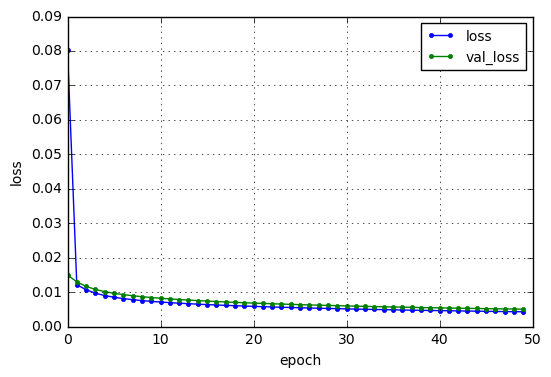

this data had finished making
hiden node = 128
_AEdim=128_Win=0512_Sld=0064_sgd
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
1s - loss: 0.1730 - val_loss: 0.0808
Epoch 2/50
1s - loss: 0.0473 - val_loss: 0.0282
Epoch 3/50
1s - loss: 0.0224 - val_loss: 0.0195
Epoch 4/50
1s - loss: 0.0179 - val_loss: 0.0174
Epoch 5/50
1s - loss: 0.0163 - val_loss: 0.0162
Epoch 6/50
1s - loss: 0.0152 - val_loss: 0.0153
Epoch 7/50
1s - loss: 0.0144 - val_loss: 0.0146
Epoch 8/50
1s - loss: 0.0138 - val_loss: 0.0140
Epoch 9/50
1s - loss: 0.0132 - val_loss: 0.0136
Epoch 10/50
1s - loss: 0.0128 - val_loss: 0.0132
Epoch 11/50
1s - loss: 0.0124 - val_loss: 0.0129
Epoch 12/50
1s - loss: 0.0121 - val_loss: 0.0126
Epoch 13/50
1s - loss: 0.0118 - val_loss: 0.0123
Epoch 14/50
1s - loss: 0.0116 - val_loss: 0.0121
Epoch 15/50
1s - loss: 0.0114 - val_loss: 0.0119
Epoch 16/50
1s - loss: 0.0112 - val_loss: 0.0118
Epoch 17/50
1s - loss: 0.0110 - val_loss: 0.0116
Epoch 18/50
1s - loss: 0.0108 - val_loss: 0.01

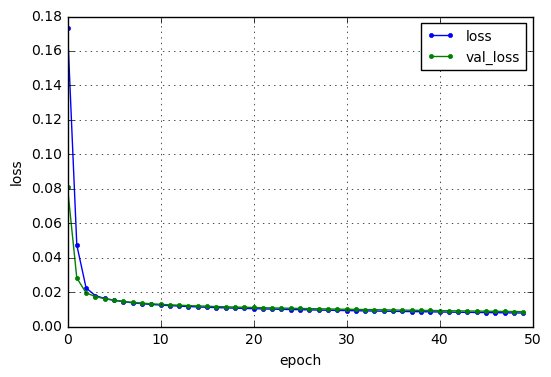

this data had finished making
hiden node = 128
_AEdim=128_Win=1024_Sld=0128_sgd
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.2744 - val_loss: 0.2375
Epoch 2/50
0s - loss: 0.2087 - val_loss: 0.1792
Epoch 3/50
0s - loss: 0.1513 - val_loss: 0.1249
Epoch 4/50
0s - loss: 0.1037 - val_loss: 0.0849
Epoch 5/50
0s - loss: 0.0714 - val_loss: 0.0598
Epoch 6/50
0s - loss: 0.0519 - val_loss: 0.0453
Epoch 7/50
0s - loss: 0.0408 - val_loss: 0.0371
Epoch 8/50
0s - loss: 0.0345 - val_loss: 0.0323
Epoch 9/50
0s - loss: 0.0307 - val_loss: 0.0294
Epoch 10/50
0s - loss: 0.0283 - val_loss: 0.0273
Epoch 11/50
0s - loss: 0.0265 - val_loss: 0.0259
Epoch 12/50
0s - loss: 0.0252 - val_loss: 0.0247
Epoch 13/50
0s - loss: 0.0241 - val_loss: 0.0237
Epoch 14/50
0s - loss: 0.0233 - val_loss: 0.0229
Epoch 15/50
0s - loss: 0.0225 - val_loss: 0.0223
Epoch 16/50
0s - loss: 0.0219 - val_loss: 0.0217
Epoch 17/50
0s - loss: 0.0213 - val_loss: 0.0212
Epoch 18/50
0s - loss: 0.0209 - val_loss: 0.0207

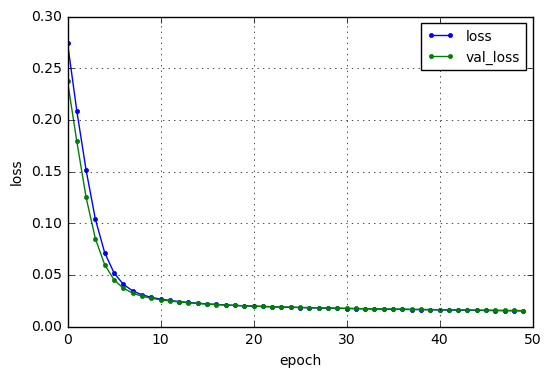

this data had finished making
hiden node = 128
_AEdim=128_Win=2048_Sld=0256_sgd
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.2937 - val_loss: 0.2779
Epoch 2/50
0s - loss: 0.2683 - val_loss: 0.2593
Epoch 3/50
0s - loss: 0.2506 - val_loss: 0.2416
Epoch 4/50
0s - loss: 0.2323 - val_loss: 0.2225
Epoch 5/50
0s - loss: 0.2126 - val_loss: 0.2025
Epoch 6/50
0s - loss: 0.1925 - val_loss: 0.1824
Epoch 7/50
0s - loss: 0.1728 - val_loss: 0.1632
Epoch 8/50
0s - loss: 0.1543 - val_loss: 0.1455
Epoch 9/50
0s - loss: 0.1375 - val_loss: 0.1296
Epoch 10/50
0s - loss: 0.1226 - val_loss: 0.1157
Epoch 11/50
0s - loss: 0.1096 - val_loss: 0.1037
Epoch 12/50
0s - loss: 0.0985 - val_loss: 0.0934
Epoch 13/50
0s - loss: 0.0890 - val_loss: 0.0847
Epoch 14/50
0s - loss: 0.0810 - val_loss: 0.0774
Epoch 15/50
0s - loss: 0.0743 - val_loss: 0.0713
Epoch 16/50
0s - loss: 0.0687 - val_loss: 0.0662
Epoch 17/50
0s - loss: 0.0640 - val_loss: 0.0619
Epoch 18/50
0s - loss: 0.0601 - val_loss: 0.0583

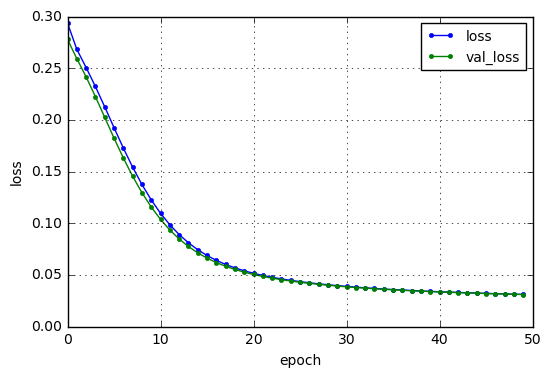

this data had finished making
hiden node = 128
_AEdim=128_Win=4096_Sld=0512_sgd
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.2973 - val_loss: 0.2914
Epoch 2/50
0s - loss: 0.2871 - val_loss: 0.2832
Epoch 3/50
0s - loss: 0.2804 - val_loss: 0.2776
Epoch 4/50
0s - loss: 0.2753 - val_loss: 0.2728
Epoch 5/50
0s - loss: 0.2706 - val_loss: 0.2681
Epoch 6/50
0s - loss: 0.2658 - val_loss: 0.2632
Epoch 7/50
0s - loss: 0.2607 - val_loss: 0.2580
Epoch 8/50
0s - loss: 0.2554 - val_loss: 0.2525
Epoch 9/50
0s - loss: 0.2497 - val_loss: 0.2467
Epoch 10/50
0s - loss: 0.2438 - val_loss: 0.2407
Epoch 11/50
0s - loss: 0.2376 - val_loss: 0.2344
Epoch 12/50
0s - loss: 0.2313 - val_loss: 0.2280
Epoch 13/50
0s - loss: 0.2249 - val_loss: 0.2215
Epoch 14/50
0s - loss: 0.2183 - val_loss: 0.2150
Epoch 15/50
0s - loss: 0.2118 - val_loss: 0.2085
Epoch 16/50
0s - loss: 0.2053 - val_loss: 0.2020
Epoch 17/50
0s - loss: 0.1989 - val_loss: 0.1957
Epoch 18/50
0s - loss: 0.1927 - val_loss: 0.1895

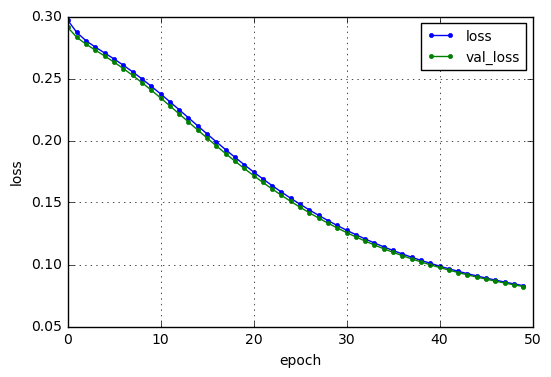

In [13]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='sgd'
AEDimention = 128

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    print "hiden node = "+str(AEDimention)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
    '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim
        
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    AutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize)

# 検証内容2

スライド幅によって学習がどのように変化するのか検証する

固定するパラメータ
* ウィンドウ幅 256
* スライド幅 256, 128, 64, 32, 16
* バッチサイズ 32
* 最適化関数　sgd
* 中間層の次元数 128

this data had finished making
_AEdim=128_Win=0256_Sld=0256_sgd
Train on 4210 samples, validate on 4210 samples
Epoch 1/50
0s - loss: 0.4386 - val_loss: 0.2354
Epoch 2/50
0s - loss: 0.1511 - val_loss: 0.0899
Epoch 3/50
0s - loss: 0.0615 - val_loss: 0.0415
Epoch 4/50
0s - loss: 0.0328 - val_loss: 0.0268
Epoch 5/50
0s - loss: 0.0242 - val_loss: 0.0223
Epoch 6/50
0s - loss: 0.0213 - val_loss: 0.0206
Epoch 7/50
0s - loss: 0.0201 - val_loss: 0.0197
Epoch 8/50
0s - loss: 0.0193 - val_loss: 0.0190
Epoch 9/50
0s - loss: 0.0187 - val_loss: 0.0185
Epoch 10/50
0s - loss: 0.0182 - val_loss: 0.0180
Epoch 11/50
0s - loss: 0.0177 - val_loss: 0.0175
Epoch 12/50
0s - loss: 0.0172 - val_loss: 0.0171
Epoch 13/50
0s - loss: 0.0168 - val_loss: 0.0166
Epoch 14/50
0s - loss: 0.0164 - val_loss: 0.0163
Epoch 15/50
0s - loss: 0.0161 - val_loss: 0.0159
Epoch 16/50
0s - loss: 0.0157 - val_loss: 0.0156
Epoch 17/50
0s - loss: 0.0154 - val_loss: 0.0153
Epoch 18/50
0s - loss: 0.0151 - val_loss: 0.0150
Epoch 19/50
0s -

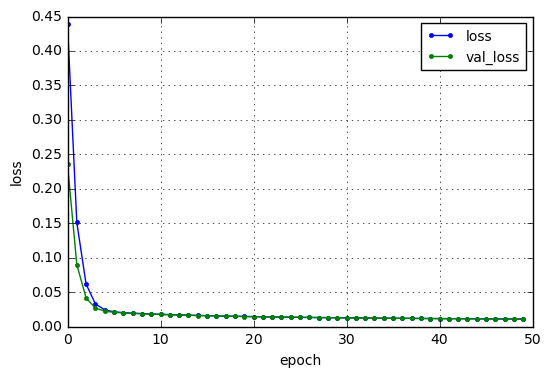

this data had finished making
_AEdim=128_Win=0256_Sld=0128_sgd
Train on 8419 samples, validate on 8419 samples
Epoch 1/50
0s - loss: 0.2971 - val_loss: 0.0864
Epoch 2/50
0s - loss: 0.0456 - val_loss: 0.0262
Epoch 3/50
0s - loss: 0.0224 - val_loss: 0.0205
Epoch 4/50
0s - loss: 0.0195 - val_loss: 0.0190
Epoch 5/50
0s - loss: 0.0183 - val_loss: 0.0180
Epoch 6/50
0s - loss: 0.0173 - val_loss: 0.0171
Epoch 7/50
0s - loss: 0.0165 - val_loss: 0.0163
Epoch 8/50
0s - loss: 0.0158 - val_loss: 0.0157
Epoch 9/50
0s - loss: 0.0152 - val_loss: 0.0151
Epoch 10/50
0s - loss: 0.0147 - val_loss: 0.0146
Epoch 11/50
0s - loss: 0.0142 - val_loss: 0.0142
Epoch 12/50
0s - loss: 0.0138 - val_loss: 0.0138
Epoch 13/50
0s - loss: 0.0134 - val_loss: 0.0135
Epoch 14/50
0s - loss: 0.0131 - val_loss: 0.0132
Epoch 15/50
0s - loss: 0.0128 - val_loss: 0.0129
Epoch 16/50
0s - loss: 0.0125 - val_loss: 0.0127
Epoch 17/50
0s - loss: 0.0123 - val_loss: 0.0124
Epoch 18/50
0s - loss: 0.0121 - val_loss: 0.0122
Epoch 19/50
0s -

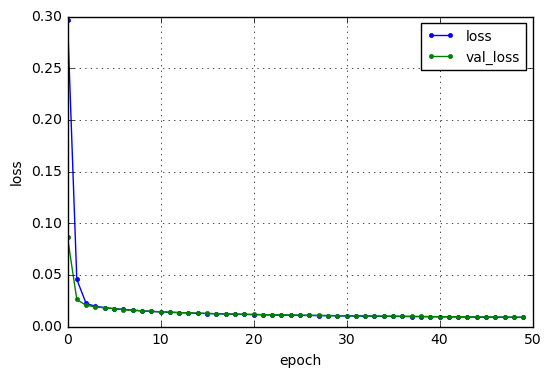

this data had finished making
_AEdim=128_Win=0256_Sld=0064_sgd
Train on 16838 samples, validate on 16838 samples
Epoch 1/50
0s - loss: 0.1502 - val_loss: 0.0271
Epoch 2/50
0s - loss: 0.0216 - val_loss: 0.0201
Epoch 3/50
0s - loss: 0.0182 - val_loss: 0.0179
Epoch 4/50
0s - loss: 0.0163 - val_loss: 0.0164
Epoch 5/50
0s - loss: 0.0150 - val_loss: 0.0152
Epoch 6/50
0s - loss: 0.0139 - val_loss: 0.0143
Epoch 7/50
0s - loss: 0.0131 - val_loss: 0.0136
Epoch 8/50
0s - loss: 0.0125 - val_loss: 0.0130
Epoch 9/50
0s - loss: 0.0120 - val_loss: 0.0125
Epoch 10/50
0s - loss: 0.0116 - val_loss: 0.0121
Epoch 11/50
0s - loss: 0.0112 - val_loss: 0.0118
Epoch 12/50
0s - loss: 0.0109 - val_loss: 0.0115
Epoch 13/50
0s - loss: 0.0107 - val_loss: 0.0112
Epoch 14/50
0s - loss: 0.0104 - val_loss: 0.0109
Epoch 15/50
0s - loss: 0.0102 - val_loss: 0.0107
Epoch 16/50
0s - loss: 0.0100 - val_loss: 0.0105
Epoch 17/50
0s - loss: 0.0098 - val_loss: 0.0103
Epoch 18/50
0s - loss: 0.0096 - val_loss: 0.0101
Epoch 19/50
0s

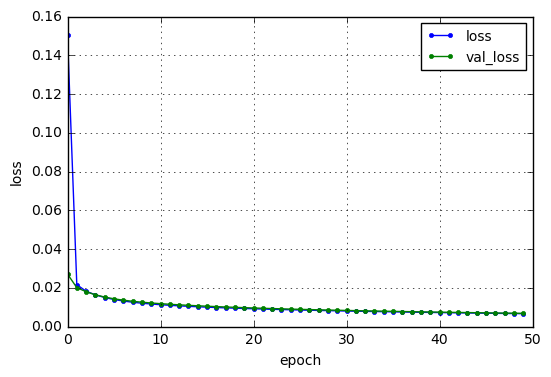

this data had finished making
_AEdim=128_Win=0256_Sld=0032_sgd
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
0s - loss: 0.0765 - val_loss: 0.0153
Epoch 2/50
0s - loss: 0.0126 - val_loss: 0.0134
Epoch 3/50
0s - loss: 0.0111 - val_loss: 0.0120
Epoch 4/50
0s - loss: 0.0100 - val_loss: 0.0111
Epoch 5/50
0s - loss: 0.0093 - val_loss: 0.0104
Epoch 6/50
1s - loss: 0.0087 - val_loss: 0.0099
Epoch 7/50
0s - loss: 0.0083 - val_loss: 0.0095
Epoch 8/50
0s - loss: 0.0080 - val_loss: 0.0092
Epoch 9/50
0s - loss: 0.0077 - val_loss: 0.0089
Epoch 10/50
0s - loss: 0.0075 - val_loss: 0.0086
Epoch 11/50
0s - loss: 0.0073 - val_loss: 0.0084
Epoch 12/50
0s - loss: 0.0071 - val_loss: 0.0082
Epoch 13/50
0s - loss: 0.0069 - val_loss: 0.0080
Epoch 14/50
0s - loss: 0.0068 - val_loss: 0.0079
Epoch 15/50
0s - loss: 0.0066 - val_loss: 0.0077
Epoch 16/50
0s - loss: 0.0065 - val_loss: 0.0076
Epoch 17/50
0s - loss: 0.0064 - val_loss: 0.0074
Epoch 18/50
0s - loss: 0.0063 - val_loss: 0.0073
Epoch 19/50
0s

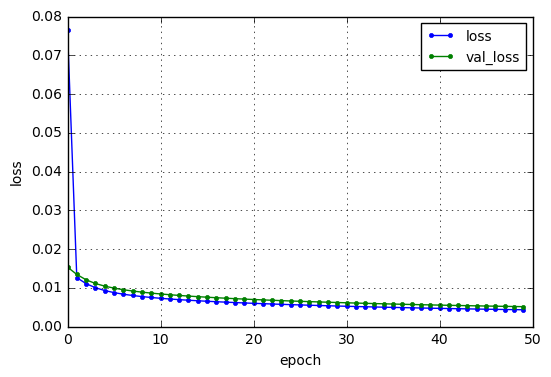

this data had finished making
_AEdim=128_Win=0256_Sld=0016_sgd
Train on 67351 samples, validate on 67351 samples
Epoch 1/50
1s - loss: 0.0558 - val_loss: 0.0169
Epoch 2/50
1s - loss: 0.0131 - val_loss: 0.0137
Epoch 3/50
1s - loss: 0.0113 - val_loss: 0.0120
Epoch 4/50
1s - loss: 0.0103 - val_loss: 0.0109
Epoch 5/50
1s - loss: 0.0096 - val_loss: 0.0101
Epoch 6/50
1s - loss: 0.0091 - val_loss: 0.0095
Epoch 7/50
1s - loss: 0.0086 - val_loss: 0.0090
Epoch 8/50
1s - loss: 0.0083 - val_loss: 0.0086
Epoch 9/50
1s - loss: 0.0079 - val_loss: 0.0082
Epoch 10/50
1s - loss: 0.0076 - val_loss: 0.0079
Epoch 11/50
1s - loss: 0.0073 - val_loss: 0.0076
Epoch 12/50
1s - loss: 0.0071 - val_loss: 0.0073
Epoch 13/50
1s - loss: 0.0069 - val_loss: 0.0071
Epoch 14/50
1s - loss: 0.0067 - val_loss: 0.0068
Epoch 15/50
1s - loss: 0.0065 - val_loss: 0.0066
Epoch 16/50
1s - loss: 0.0063 - val_loss: 0.0064
Epoch 17/50
1s - loss: 0.0061 - val_loss: 0.0062
Epoch 18/50
1s - loss: 0.0059 - val_loss: 0.0061
Epoch 19/50
1s

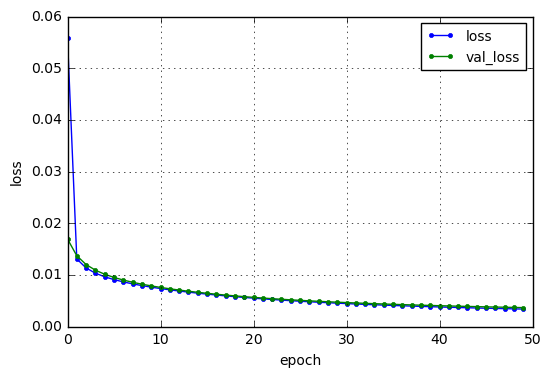

In [19]:
# loop windowWidth
WindowWidth = 256
SlidingWidth = np.array([256,128,64,32,16])
BatchSize = 32
Optim='sgd'
AEDimention =128

WindowNum = WindowWidth

for SlidingNum in SlidingWidth:
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
    '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    AutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize)

# 検証内容3

最適化関数を変更し，結果を確かめる

固定するパラメータ
* ウィンドウ幅 [256,512,1024,2048,4096]
* スライド幅 ウィンドウ幅/8
* バッチサイズ 32
* 最適化関数　adam
* 中間層の次元数 128

this data had finished making
hiden node = 128
_AEdim=128_Win=0256_Sld=0032_adam
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
0s - loss: 0.0132 - val_loss: 0.0280
Epoch 2/50
0s - loss: 0.0077 - val_loss: 0.0357
Epoch 3/50
0s - loss: 0.0075 - val_loss: 0.0291
Epoch 4/50
1s - loss: 0.0065 - val_loss: 0.0215
Epoch 5/50
0s - loss: 0.0062 - val_loss: 0.0175
Epoch 6/50
0s - loss: 0.0056 - val_loss: 0.0143
Epoch 7/50
0s - loss: 0.0053 - val_loss: 0.0120
Epoch 8/50
0s - loss: 0.0047 - val_loss: 0.0154
Epoch 9/50
0s - loss: 0.0048 - val_loss: 0.0120
Epoch 10/50
0s - loss: 0.0045 - val_loss: 0.0174
Epoch 11/50
0s - loss: 0.0049 - val_loss: 0.0091
Epoch 12/50
0s - loss: 0.0040 - val_loss: 0.0126
Epoch 13/50
0s - loss: 0.0042 - val_loss: 0.0111
Epoch 14/50
0s - loss: 0.0041 - val_loss: 0.0101
Epoch 15/50
0s - loss: 0.0041 - val_loss: 0.0151
Epoch 16/50
0s - loss: 0.0039 - val_loss: 0.0159
Epoch 17/50
0s - loss: 0.0037 - val_loss: 0.0132
Epoch 18/50
1s - loss: 0.0042 - val_loss: 0.0

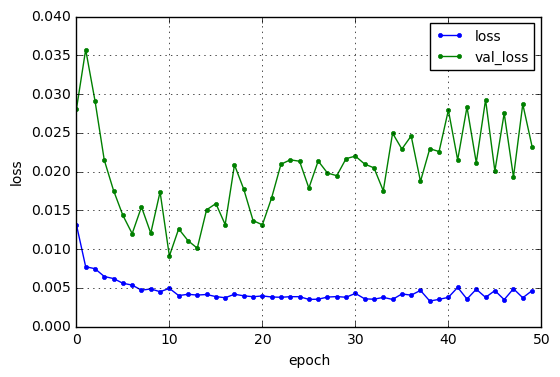

this data had finished making
hiden node = 128
_AEdim=128_Win=0512_Sld=0064_adam
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.0238 - val_loss: 0.0367
Epoch 2/50
0s - loss: 0.0074 - val_loss: 0.0197
Epoch 3/50
0s - loss: 0.0060 - val_loss: 0.0096
Epoch 4/50
0s - loss: 0.0051 - val_loss: 0.0074
Epoch 5/50
0s - loss: 0.0053 - val_loss: 0.0084
Epoch 6/50
0s - loss: 0.0054 - val_loss: 0.0066
Epoch 7/50
0s - loss: 0.0050 - val_loss: 0.0107
Epoch 8/50
0s - loss: 0.0049 - val_loss: 0.0099
Epoch 9/50
0s - loss: 0.0056 - val_loss: 0.0076
Epoch 10/50
0s - loss: 0.0044 - val_loss: 0.0125
Epoch 11/50
0s - loss: 0.0054 - val_loss: 0.0051
Epoch 12/50
0s - loss: 0.0038 - val_loss: 0.0091
Epoch 13/50
0s - loss: 0.0043 - val_loss: 0.0069
Epoch 14/50
0s - loss: 0.0035 - val_loss: 0.0043
Epoch 15/50
0s - loss: 0.0047 - val_loss: 0.0087
Epoch 16/50
0s - loss: 0.0051 - val_loss: 0.0100
Epoch 17/50
0s - loss: 0.0050 - val_loss: 0.0053
Epoch 18/50
0s - loss: 0.0052 - val_loss: 0.0

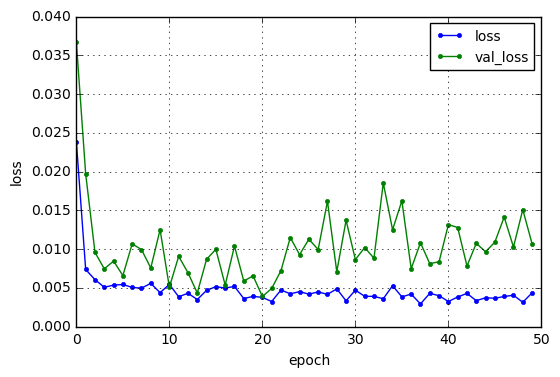

this data had finished making
hiden node = 128
_AEdim=128_Win=1024_Sld=0128_adam
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.0351 - val_loss: 0.0103
Epoch 2/50
0s - loss: 0.0108 - val_loss: 0.0092
Epoch 3/50
0s - loss: 0.0097 - val_loss: 0.0085
Epoch 4/50
0s - loss: 0.0092 - val_loss: 0.0092
Epoch 5/50
0s - loss: 0.0082 - val_loss: 0.0084
Epoch 6/50
0s - loss: 0.0078 - val_loss: 0.0085
Epoch 7/50
0s - loss: 0.0085 - val_loss: 0.0162
Epoch 8/50
0s - loss: 0.0078 - val_loss: 0.0069
Epoch 9/50
0s - loss: 0.0073 - val_loss: 0.0076
Epoch 10/50
0s - loss: 0.0074 - val_loss: 0.0066
Epoch 11/50
0s - loss: 0.0080 - val_loss: 0.0067
Epoch 12/50
0s - loss: 0.0075 - val_loss: 0.0105
Epoch 13/50
0s - loss: 0.0069 - val_loss: 0.0072
Epoch 14/50
0s - loss: 0.0075 - val_loss: 0.0069
Epoch 15/50
0s - loss: 0.0091 - val_loss: 0.0068
Epoch 16/50
0s - loss: 0.0083 - val_loss: 0.0068
Epoch 17/50
0s - loss: 0.0074 - val_loss: 0.0068
Epoch 18/50
0s - loss: 0.0077 - val_loss: 0.006

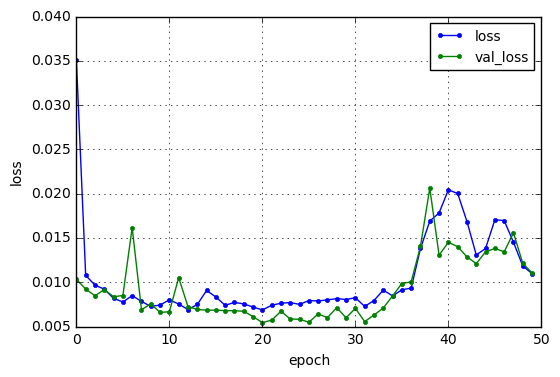

this data had finished making
hiden node = 128
_AEdim=128_Win=2048_Sld=0256_adam
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.0562 - val_loss: 0.0244
Epoch 2/50
0s - loss: 0.0460 - val_loss: 0.0397
Epoch 3/50
0s - loss: 0.0453 - val_loss: 0.0306
Epoch 4/50
0s - loss: 0.0451 - val_loss: 0.0337
Epoch 5/50
0s - loss: 0.0447 - val_loss: 0.0317
Epoch 6/50
0s - loss: 0.0462 - val_loss: 0.0361
Epoch 7/50
0s - loss: 0.0513 - val_loss: 0.0432
Epoch 8/50
0s - loss: 0.0545 - val_loss: 0.0428
Epoch 9/50
0s - loss: 0.0535 - val_loss: 0.0432
Epoch 10/50
0s - loss: 0.0520 - val_loss: 0.0437
Epoch 11/50
0s - loss: 0.0519 - val_loss: 0.0414
Epoch 12/50
0s - loss: 0.0480 - val_loss: 0.0424
Epoch 13/50
0s - loss: 0.0542 - val_loss: 0.0470
Epoch 14/50
0s - loss: 0.0555 - val_loss: 0.0391
Epoch 15/50
0s - loss: 0.0586 - val_loss: 0.0436
Epoch 16/50
0s - loss: 0.0534 - val_loss: 0.0443
Epoch 17/50
0s - loss: 0.0507 - val_loss: 0.0467
Epoch 18/50
0s - loss: 0.0584 - val_loss: 0.043

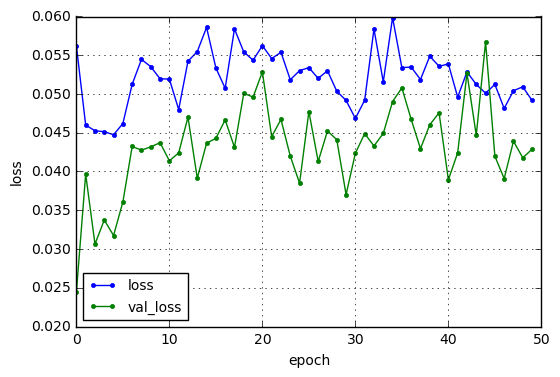

this data had finished making
hiden node = 128
_AEdim=128_Win=4096_Sld=0512_adam
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.1008 - val_loss: 0.0623
Epoch 2/50
0s - loss: 0.0528 - val_loss: 0.0551
Epoch 3/50
0s - loss: 0.0523 - val_loss: 0.0607
Epoch 4/50
0s - loss: 0.0516 - val_loss: 0.0642
Epoch 5/50
0s - loss: 0.0567 - val_loss: 0.0656
Epoch 6/50
0s - loss: 0.0571 - val_loss: 0.0721
Epoch 7/50
0s - loss: 0.0528 - val_loss: 0.0731
Epoch 8/50
0s - loss: 0.0538 - val_loss: 0.0767
Epoch 9/50
0s - loss: 0.0536 - val_loss: 0.0815
Epoch 10/50
0s - loss: 0.0555 - val_loss: 0.0712
Epoch 11/50
0s - loss: 0.0522 - val_loss: 0.0799
Epoch 12/50
0s - loss: 0.0519 - val_loss: 0.0819
Epoch 13/50
0s - loss: 0.0515 - val_loss: 0.0810
Epoch 14/50
0s - loss: 0.0529 - val_loss: 0.0715
Epoch 15/50
0s - loss: 0.0525 - val_loss: 0.0878
Epoch 16/50
0s - loss: 0.0537 - val_loss: 0.0896
Epoch 17/50
0s - loss: 0.0534 - val_loss: 0.0860
Epoch 18/50
0s - loss: 0.0499 - val_loss: 0.081

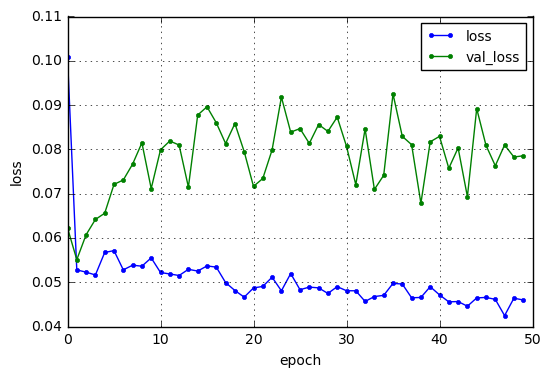

In [15]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='adam'
AEDimention = 128

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    print "hiden node = "+str(AEDimention)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
    '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    AutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize)

# 検証内容4

最適化関数を変更し，結果を確かめる

固定するパラメータ
* ウィンドウ幅 [256,512,1024,2048,4096]
* スライド幅 ウィンドウ幅/8
* バッチサイズ 32
* 最適化関数　Adagrad
* 中間層の次元数 128

this data had finished making
hiden node = 128
_AEdim=128_Win=0256_Sld=0032_Adagrad
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
0s - loss: 0.0097 - val_loss: 0.0051
Epoch 2/50
0s - loss: 0.0036 - val_loss: 0.0037
Epoch 3/50
1s - loss: 0.0029 - val_loss: 0.0030
Epoch 4/50
0s - loss: 0.0026 - val_loss: 0.0026
Epoch 5/50
0s - loss: 0.0023 - val_loss: 0.0024
Epoch 6/50
1s - loss: 0.0021 - val_loss: 0.0022
Epoch 7/50
0s - loss: 0.0020 - val_loss: 0.0021
Epoch 8/50
0s - loss: 0.0019 - val_loss: 0.0020
Epoch 9/50
0s - loss: 0.0018 - val_loss: 0.0019
Epoch 10/50
0s - loss: 0.0017 - val_loss: 0.0018
Epoch 11/50
0s - loss: 0.0017 - val_loss: 0.0017
Epoch 12/50
0s - loss: 0.0016 - val_loss: 0.0016
Epoch 13/50
0s - loss: 0.0016 - val_loss: 0.0016
Epoch 14/50
0s - loss: 0.0015 - val_loss: 0.0015
Epoch 15/50
0s - loss: 0.0015 - val_loss: 0.0015
Epoch 16/50
0s - loss: 0.0014 - val_loss: 0.0014
Epoch 17/50
0s - loss: 0.0014 - val_loss: 0.0014
Epoch 18/50
0s - loss: 0.0013 - val_loss: 

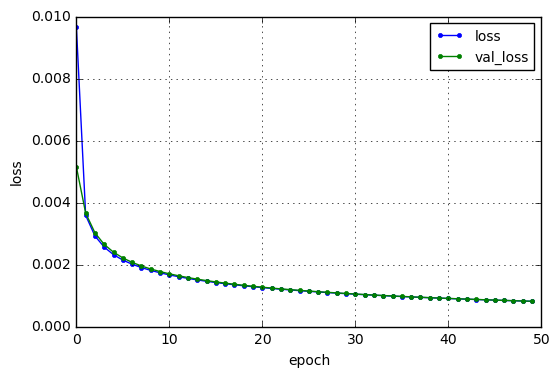

this data had finished making
hiden node = 128
_AEdim=128_Win=0512_Sld=0064_Adagrad
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.0193 - val_loss: 0.0107
Epoch 2/50
0s - loss: 0.0073 - val_loss: 0.0072
Epoch 3/50
0s - loss: 0.0060 - val_loss: 0.0061
Epoch 4/50
0s - loss: 0.0052 - val_loss: 0.0054
Epoch 5/50
0s - loss: 0.0047 - val_loss: 0.0049
Epoch 6/50
0s - loss: 0.0043 - val_loss: 0.0045
Epoch 7/50
0s - loss: 0.0040 - val_loss: 0.0042
Epoch 8/50
0s - loss: 0.0038 - val_loss: 0.0039
Epoch 9/50
0s - loss: 0.0035 - val_loss: 0.0036
Epoch 10/50
0s - loss: 0.0034 - val_loss: 0.0034
Epoch 11/50
0s - loss: 0.0032 - val_loss: 0.0032
Epoch 12/50
0s - loss: 0.0030 - val_loss: 0.0031
Epoch 13/50
0s - loss: 0.0029 - val_loss: 0.0029
Epoch 14/50
0s - loss: 0.0028 - val_loss: 0.0028
Epoch 15/50
0s - loss: 0.0027 - val_loss: 0.0027
Epoch 16/50
0s - loss: 0.0026 - val_loss: 0.0026
Epoch 17/50
0s - loss: 0.0025 - val_loss: 0.0025
Epoch 18/50
0s - loss: 0.0024 - val_loss: 

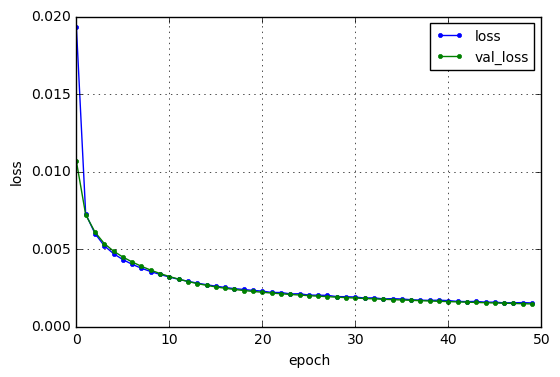

this data had finished making
hiden node = 128
_AEdim=128_Win=1024_Sld=0128_Adagrad
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.0412 - val_loss: 0.0163
Epoch 2/50
0s - loss: 0.0156 - val_loss: 0.0121
Epoch 3/50
0s - loss: 0.0111 - val_loss: 0.0102
Epoch 4/50
0s - loss: 0.0095 - val_loss: 0.0092
Epoch 5/50
0s - loss: 0.0085 - val_loss: 0.0086
Epoch 6/50
0s - loss: 0.0079 - val_loss: 0.0081
Epoch 7/50
0s - loss: 0.0074 - val_loss: 0.0077
Epoch 8/50
0s - loss: 0.0070 - val_loss: 0.0074
Epoch 9/50
0s - loss: 0.0066 - val_loss: 0.0071
Epoch 10/50
0s - loss: 0.0064 - val_loss: 0.0069
Epoch 11/50
0s - loss: 0.0061 - val_loss: 0.0067
Epoch 12/50
0s - loss: 0.0059 - val_loss: 0.0065
Epoch 13/50
0s - loss: 0.0057 - val_loss: 0.0063
Epoch 14/50
0s - loss: 0.0055 - val_loss: 0.0061
Epoch 15/50
0s - loss: 0.0054 - val_loss: 0.0060
Epoch 16/50
0s - loss: 0.0052 - val_loss: 0.0059
Epoch 17/50
0s - loss: 0.0051 - val_loss: 0.0057
Epoch 18/50
0s - loss: 0.0050 - val_loss: 0.

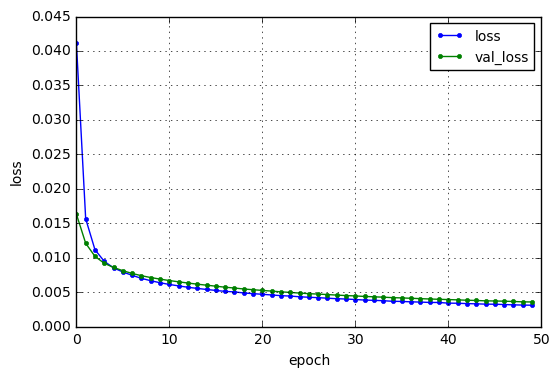

this data had finished making
hiden node = 128
_AEdim=128_Win=2048_Sld=0256_Adagrad
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.0822 - val_loss: 0.0960
Epoch 2/50
0s - loss: 0.0419 - val_loss: 0.0391
Epoch 3/50
0s - loss: 0.0355 - val_loss: 0.0291
Epoch 4/50
0s - loss: 0.0339 - val_loss: 0.0302
Epoch 5/50
0s - loss: 0.0302 - val_loss: 0.0288
Epoch 6/50
0s - loss: 0.0271 - val_loss: 0.0275
Epoch 7/50
0s - loss: 0.0252 - val_loss: 0.0246
Epoch 8/50
0s - loss: 0.0260 - val_loss: 0.0262
Epoch 9/50
0s - loss: 0.0213 - val_loss: 0.0232
Epoch 10/50
0s - loss: 0.0251 - val_loss: 0.0246
Epoch 11/50
0s - loss: 0.0238 - val_loss: 0.0240
Epoch 12/50
0s - loss: 0.0236 - val_loss: 0.0262
Epoch 13/50
0s - loss: 0.0202 - val_loss: 0.0244
Epoch 14/50
0s - loss: 0.0187 - val_loss: 0.0239
Epoch 15/50
0s - loss: 0.0169 - val_loss: 0.0224
Epoch 16/50
0s - loss: 0.0153 - val_loss: 0.0206
Epoch 17/50
0s - loss: 0.0138 - val_loss: 0.0188
Epoch 18/50
0s - loss: 0.0133 - val_loss: 0.

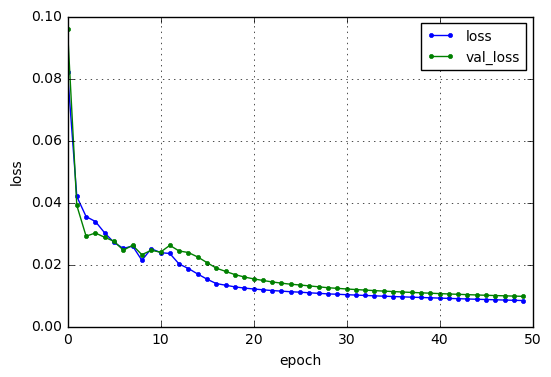

this data had finished making
hiden node = 128
_AEdim=128_Win=4096_Sld=0512_Adagrad
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.1227 - val_loss: 0.0758
Epoch 2/50
0s - loss: 0.0573 - val_loss: 0.0679
Epoch 3/50
0s - loss: 0.0556 - val_loss: 0.0734
Epoch 4/50
0s - loss: 0.0514 - val_loss: 0.0637
Epoch 5/50
0s - loss: 0.0492 - val_loss: 0.0669
Epoch 6/50
0s - loss: 0.0477 - val_loss: 0.0607
Epoch 7/50
0s - loss: 0.0464 - val_loss: 0.0615
Epoch 8/50
0s - loss: 0.0470 - val_loss: 0.0590
Epoch 9/50
0s - loss: 0.0478 - val_loss: 0.0638
Epoch 10/50
0s - loss: 0.0432 - val_loss: 0.0587
Epoch 11/50
0s - loss: 0.0429 - val_loss: 0.0529
Epoch 12/50
0s - loss: 0.0431 - val_loss: 0.0592
Epoch 13/50
0s - loss: 0.0418 - val_loss: 0.0561
Epoch 14/50
0s - loss: 0.0428 - val_loss: 0.0568
Epoch 15/50
0s - loss: 0.0410 - val_loss: 0.0527
Epoch 16/50
0s - loss: 0.0421 - val_loss: 0.0537
Epoch 17/50
0s - loss: 0.0404 - val_loss: 0.0532
Epoch 18/50
0s - loss: 0.0396 - val_loss: 0.

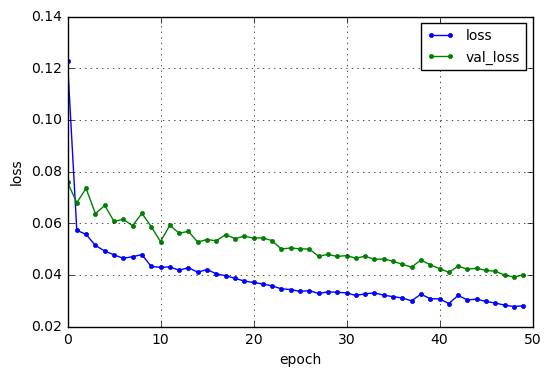

In [16]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='Adagrad'
AEDimention = 128

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    print "hiden node = "+str(AEDimention)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
    '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    AutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize)

# 検証内容5

最適化関数を変更し，結果を確かめる

固定するパラメータ
* ウィンドウ幅 [256,512,1024,2048,4096]
* スライド幅 ウィンドウ幅/8
* バッチサイズ 32
* 最適化関数　Adadelta
* 中間層の次元数 128

this data had finished making
hiden node = 128
_AEdim=128_Win=0256_Sld=0032_Adadelta
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.0140 - val_loss: 0.0045
Epoch 2/50
0s - loss: 0.0037 - val_loss: 0.0036
Epoch 3/50
0s - loss: 0.0031 - val_loss: 0.0031
Epoch 4/50
0s - loss: 0.0028 - val_loss: 0.0029
Epoch 5/50
0s - loss: 0.0026 - val_loss: 0.0027
Epoch 6/50
0s - loss: 0.0025 - val_loss: 0.0026
Epoch 7/50
1s - loss: 0.0024 - val_loss: 0.0025
Epoch 8/50
1s - loss: 0.0023 - val_loss: 0.0024
Epoch 9/50
0s - loss: 0.0022 - val_loss: 0.0023
Epoch 10/50
0s - loss: 0.0021 - val_loss: 0.0023
Epoch 11/50
0s - loss: 0.0021 - val_loss: 0.0022
Epoch 12/50
0s - loss: 0.0020 - val_loss: 0.0022
Epoch 13/50
0s - loss: 0.0020 - val_loss: 0.0021
Epoch 14/50
0s - loss: 0.0020 - val_loss: 0.0021
Epoch 15/50
0s - loss: 0.0019 - val_loss: 0.0020
Epoch 16/50
0s - loss: 0.0019 - val_loss: 0.0020
Epoch 17/50
0s - loss: 0.0018 - val_loss: 0.0020
Epoch 18/50
0s - loss: 0.0018 - val_loss:

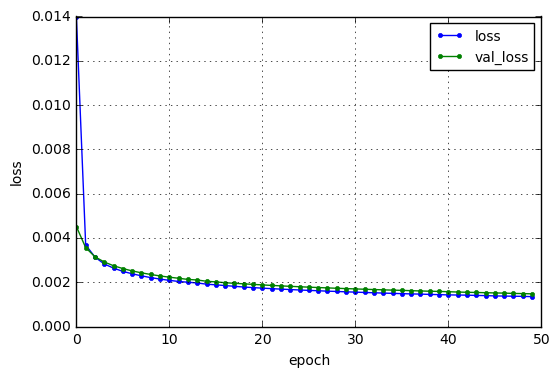

this data had finished making
hiden node = 128
_AEdim=128_Win=0512_Sld=0064_Adadelta
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.0236 - val_loss: 0.0080
Epoch 2/50
0s - loss: 0.0063 - val_loss: 0.0062
Epoch 3/50
0s - loss: 0.0055 - val_loss: 0.0055
Epoch 4/50
0s - loss: 0.0051 - val_loss: 0.0051
Epoch 5/50
0s - loss: 0.0047 - val_loss: 0.0047
Epoch 6/50
0s - loss: 0.0045 - val_loss: 0.0045
Epoch 7/50
0s - loss: 0.0043 - val_loss: 0.0043
Epoch 8/50
0s - loss: 0.0041 - val_loss: 0.0041
Epoch 9/50
0s - loss: 0.0040 - val_loss: 0.0040
Epoch 10/50
0s - loss: 0.0038 - val_loss: 0.0038
Epoch 11/50
0s - loss: 0.0037 - val_loss: 0.0037
Epoch 12/50
0s - loss: 0.0036 - val_loss: 0.0036
Epoch 13/50
0s - loss: 0.0035 - val_loss: 0.0036
Epoch 14/50
0s - loss: 0.0035 - val_loss: 0.0035
Epoch 15/50
0s - loss: 0.0034 - val_loss: 0.0034
Epoch 16/50
0s - loss: 0.0033 - val_loss: 0.0034
Epoch 17/50
0s - loss: 0.0033 - val_loss: 0.0033
Epoch 18/50
0s - loss: 0.0032 - val_loss:

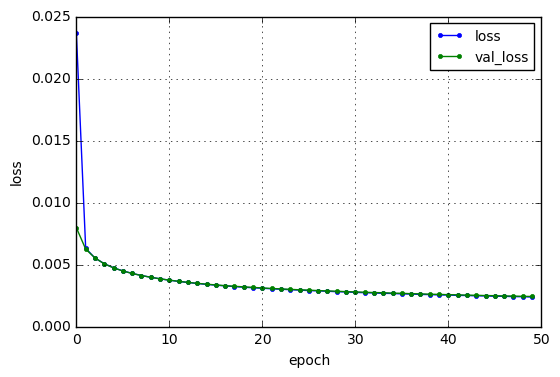

this data had finished making
hiden node = 128
_AEdim=128_Win=1024_Sld=0128_Adadelta
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.0413 - val_loss: 0.0156
Epoch 2/50
0s - loss: 0.0110 - val_loss: 0.0110
Epoch 3/50
0s - loss: 0.0093 - val_loss: 0.0098
Epoch 4/50
0s - loss: 0.0087 - val_loss: 0.0091
Epoch 5/50
0s - loss: 0.0083 - val_loss: 0.0086
Epoch 6/50
0s - loss: 0.0079 - val_loss: 0.0082
Epoch 7/50
0s - loss: 0.0077 - val_loss: 0.0079
Epoch 8/50
0s - loss: 0.0075 - val_loss: 0.0077
Epoch 9/50
0s - loss: 0.0073 - val_loss: 0.0074
Epoch 10/50
0s - loss: 0.0071 - val_loss: 0.0072
Epoch 11/50
0s - loss: 0.0070 - val_loss: 0.0071
Epoch 12/50
0s - loss: 0.0069 - val_loss: 0.0069
Epoch 13/50
0s - loss: 0.0067 - val_loss: 0.0068
Epoch 14/50
0s - loss: 0.0066 - val_loss: 0.0067
Epoch 15/50
0s - loss: 0.0065 - val_loss: 0.0065
Epoch 16/50
0s - loss: 0.0064 - val_loss: 0.0064
Epoch 17/50
0s - loss: 0.0064 - val_loss: 0.0063
Epoch 18/50
0s - loss: 0.0063 - val_loss: 0

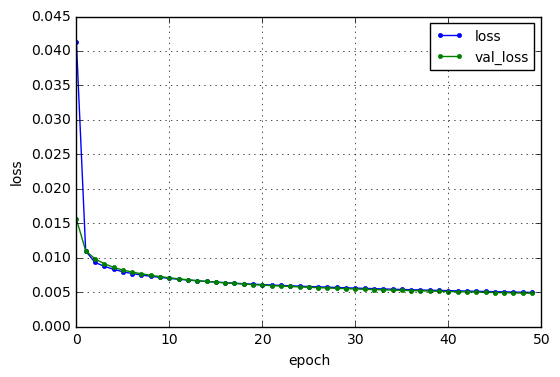

this data had finished making
hiden node = 128
_AEdim=128_Win=2048_Sld=0256_Adadelta
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.0689 - val_loss: 0.0289
Epoch 2/50
0s - loss: 0.0221 - val_loss: 0.0212
Epoch 3/50
0s - loss: 0.0174 - val_loss: 0.0178
Epoch 4/50
0s - loss: 0.0155 - val_loss: 0.0162
Epoch 5/50
0s - loss: 0.0144 - val_loss: 0.0150
Epoch 6/50
0s - loss: 0.0135 - val_loss: 0.0140
Epoch 7/50
0s - loss: 0.0129 - val_loss: 0.0133
Epoch 8/50
0s - loss: 0.0123 - val_loss: 0.0128
Epoch 9/50
0s - loss: 0.0120 - val_loss: 0.0124
Epoch 10/50
0s - loss: 0.0117 - val_loss: 0.0120
Epoch 11/50
0s - loss: 0.0114 - val_loss: 0.0118
Epoch 12/50
0s - loss: 0.0112 - val_loss: 0.0115
Epoch 13/50
0s - loss: 0.0110 - val_loss: 0.0113
Epoch 14/50
0s - loss: 0.0108 - val_loss: 0.0111
Epoch 15/50
0s - loss: 0.0106 - val_loss: 0.0109
Epoch 16/50
0s - loss: 0.0105 - val_loss: 0.0108
Epoch 17/50
0s - loss: 0.0104 - val_loss: 0.0107
Epoch 18/50
0s - loss: 0.0103 - val_loss: 0

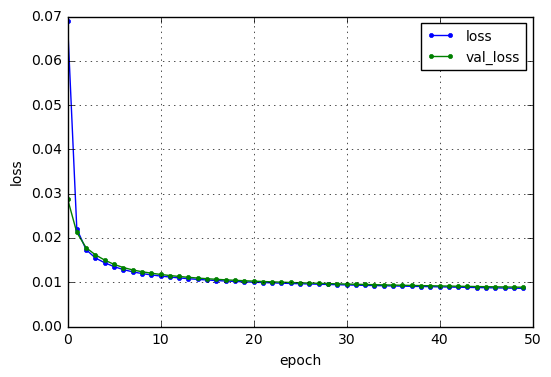

this data had finished making
hiden node = 128
_AEdim=128_Win=4096_Sld=0512_Adadelta
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.1283 - val_loss: 0.0568
Epoch 2/50
0s - loss: 0.0463 - val_loss: 0.0453
Epoch 3/50
0s - loss: 0.0387 - val_loss: 0.0404
Epoch 4/50
0s - loss: 0.0338 - val_loss: 0.0361
Epoch 5/50
0s - loss: 0.0301 - val_loss: 0.0328
Epoch 6/50
0s - loss: 0.0276 - val_loss: 0.0303
Epoch 7/50
0s - loss: 0.0257 - val_loss: 0.0285
Epoch 8/50
0s - loss: 0.0243 - val_loss: 0.0271
Epoch 9/50
0s - loss: 0.0232 - val_loss: 0.0259
Epoch 10/50
0s - loss: 0.0223 - val_loss: 0.0251
Epoch 11/50
0s - loss: 0.0216 - val_loss: 0.0244
Epoch 12/50
0s - loss: 0.0209 - val_loss: 0.0238
Epoch 13/50
0s - loss: 0.0204 - val_loss: 0.0232
Epoch 14/50
0s - loss: 0.0199 - val_loss: 0.0228
Epoch 15/50
0s - loss: 0.0195 - val_loss: 0.0223
Epoch 16/50
0s - loss: 0.0191 - val_loss: 0.0219
Epoch 17/50
0s - loss: 0.0187 - val_loss: 0.0216
Epoch 18/50
0s - loss: 0.0184 - val_loss: 0

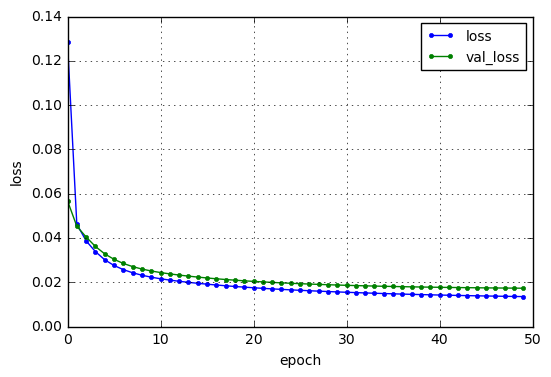

In [17]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='Adadelta'
AEDimention = 128

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    print "hiden node = "+str(AEDimention)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
    '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    AutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize)

# 検証内容6

最適化関数を変更し，結果を確かめる

固定するパラメータ
* ウィンドウ幅 [256,512,1024,2048,4096]
* スライド幅 ウィンドウ幅/8
* バッチサイズ 32
* 最適化関数　Adamax
* 中間層の次元数 128

this data had finished making
hiden node = 128
_AEdim=128_Win=0256_Sld=0032_Adamax
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
0s - loss: 0.0114 - val_loss: 0.0066
Epoch 2/50
0s - loss: 0.0048 - val_loss: 0.0043
Epoch 3/50
0s - loss: 0.0041 - val_loss: 0.0038
Epoch 4/50
0s - loss: 0.0038 - val_loss: 0.0043
Epoch 5/50
0s - loss: 0.0035 - val_loss: 0.0060
Epoch 6/50
0s - loss: 0.0032 - val_loss: 0.0079
Epoch 7/50
0s - loss: 0.0030 - val_loss: 0.0061
Epoch 8/50
0s - loss: 0.0029 - val_loss: 0.0138
Epoch 9/50
0s - loss: 0.0027 - val_loss: 0.0127
Epoch 10/50
0s - loss: 0.0026 - val_loss: 0.0087
Epoch 11/50
0s - loss: 0.0024 - val_loss: 0.0125
Epoch 12/50
0s - loss: 0.0025 - val_loss: 0.0137
Epoch 13/50
0s - loss: 0.0023 - val_loss: 0.0120
Epoch 14/50
0s - loss: 0.0023 - val_loss: 0.0099
Epoch 15/50
0s - loss: 0.0023 - val_loss: 0.0104
Epoch 16/50
0s - loss: 0.0021 - val_loss: 0.0057
Epoch 17/50
0s - loss: 0.0023 - val_loss: 0.0116
Epoch 18/50
0s - loss: 0.0021 - val_loss: 0

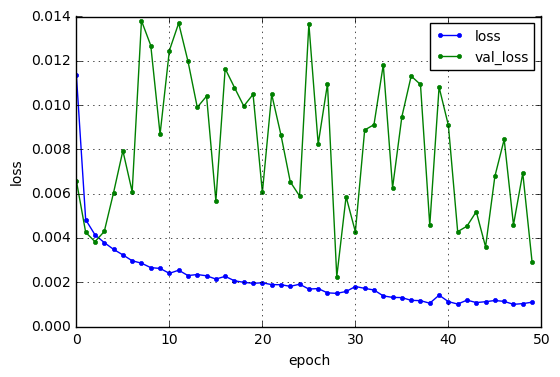

this data had finished making
hiden node = 128
_AEdim=128_Win=0512_Sld=0064_Adamax
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.0202 - val_loss: 0.0089
Epoch 2/50
0s - loss: 0.0075 - val_loss: 0.0125
Epoch 3/50
0s - loss: 0.0074 - val_loss: 0.0159
Epoch 4/50
0s - loss: 0.0050 - val_loss: 0.0261
Epoch 5/50
0s - loss: 0.0063 - val_loss: 0.0141
Epoch 6/50
0s - loss: 0.0058 - val_loss: 0.0098
Epoch 7/50
0s - loss: 0.0050 - val_loss: 0.0092
Epoch 8/50
0s - loss: 0.0044 - val_loss: 0.0090
Epoch 9/50
0s - loss: 0.0041 - val_loss: 0.0091
Epoch 10/50
0s - loss: 0.0044 - val_loss: 0.0083
Epoch 11/50
0s - loss: 0.0027 - val_loss: 0.0052
Epoch 12/50
0s - loss: 0.0028 - val_loss: 0.0071
Epoch 13/50
0s - loss: 0.0030 - val_loss: 0.0065
Epoch 14/50
0s - loss: 0.0026 - val_loss: 0.0074
Epoch 15/50
0s - loss: 0.0032 - val_loss: 0.0071
Epoch 16/50
0s - loss: 0.0025 - val_loss: 0.0107
Epoch 17/50
0s - loss: 0.0029 - val_loss: 0.0064
Epoch 18/50
0s - loss: 0.0022 - val_loss: 0

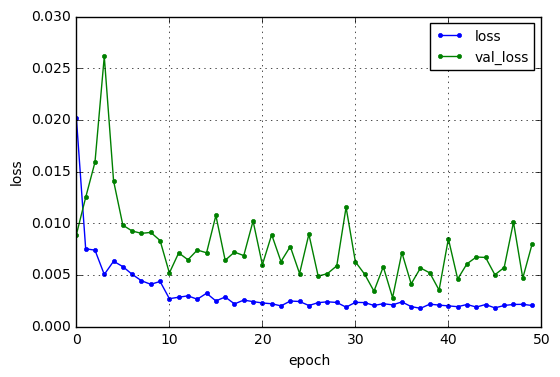

this data had finished making
hiden node = 128
_AEdim=128_Win=1024_Sld=0128_Adamax
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.0369 - val_loss: 0.0131
Epoch 2/50
0s - loss: 0.0113 - val_loss: 0.0105
Epoch 3/50
0s - loss: 0.0095 - val_loss: 0.0086
Epoch 4/50
0s - loss: 0.0082 - val_loss: 0.0077
Epoch 5/50
0s - loss: 0.0077 - val_loss: 0.0076
Epoch 6/50
0s - loss: 0.0068 - val_loss: 0.0065
Epoch 7/50
0s - loss: 0.0065 - val_loss: 0.0061
Epoch 8/50
0s - loss: 0.0061 - val_loss: 0.0056
Epoch 9/50
0s - loss: 0.0057 - val_loss: 0.0053
Epoch 10/50
0s - loss: 0.0055 - val_loss: 0.0048
Epoch 11/50
0s - loss: 0.0052 - val_loss: 0.0050
Epoch 12/50
0s - loss: 0.0049 - val_loss: 0.0040
Epoch 13/50
0s - loss: 0.0046 - val_loss: 0.0039
Epoch 14/50
0s - loss: 0.0045 - val_loss: 0.0045
Epoch 15/50
0s - loss: 0.0043 - val_loss: 0.0036
Epoch 16/50
0s - loss: 0.0044 - val_loss: 0.0041
Epoch 17/50
0s - loss: 0.0045 - val_loss: 0.0045
Epoch 18/50
0s - loss: 0.0043 - val_loss: 0.0

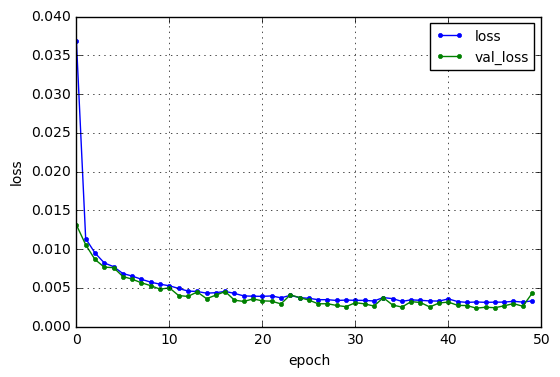

this data had finished making
hiden node = 128
_AEdim=128_Win=2048_Sld=0256_Adamax
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.0656 - val_loss: 0.0349
Epoch 2/50
0s - loss: 0.0223 - val_loss: 0.0250
Epoch 3/50
0s - loss: 0.0146 - val_loss: 0.0178
Epoch 4/50
0s - loss: 0.0120 - val_loss: 0.0127
Epoch 5/50
0s - loss: 0.0113 - val_loss: 0.0113
Epoch 6/50
0s - loss: 0.0111 - val_loss: 0.0105
Epoch 7/50
0s - loss: 0.0107 - val_loss: 0.0101
Epoch 8/50
0s - loss: 0.0108 - val_loss: 0.0097
Epoch 9/50
0s - loss: 0.0104 - val_loss: 0.0101
Epoch 10/50
0s - loss: 0.0104 - val_loss: 0.0102
Epoch 11/50
0s - loss: 0.0109 - val_loss: 0.0100
Epoch 12/50
0s - loss: 0.0114 - val_loss: 0.0099
Epoch 13/50
0s - loss: 0.0110 - val_loss: 0.0099
Epoch 14/50
0s - loss: 0.0107 - val_loss: 0.0096
Epoch 15/50
0s - loss: 0.0099 - val_loss: 0.0094
Epoch 16/50
0s - loss: 0.0104 - val_loss: 0.0094
Epoch 17/50
0s - loss: 0.0092 - val_loss: 0.0091
Epoch 18/50
0s - loss: 0.0090 - val_loss: 0.0

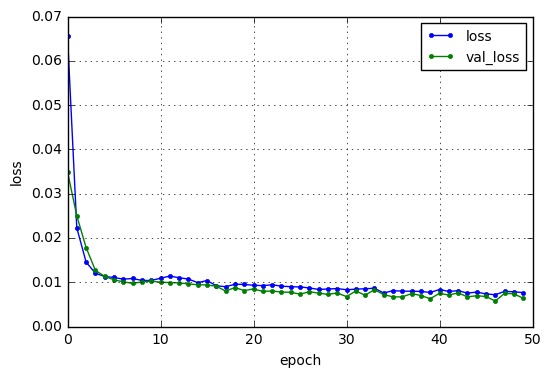

this data had finished making
hiden node = 128
_AEdim=128_Win=4096_Sld=0512_Adamax
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.1139 - val_loss: 0.0764
Epoch 2/50
0s - loss: 0.0518 - val_loss: 0.0682
Epoch 3/50
0s - loss: 0.0436 - val_loss: 0.0672
Epoch 4/50
0s - loss: 0.0408 - val_loss: 0.0609
Epoch 5/50
0s - loss: 0.0369 - val_loss: 0.0612
Epoch 6/50
0s - loss: 0.0350 - val_loss: 0.0593
Epoch 7/50
0s - loss: 0.0338 - val_loss: 0.0559
Epoch 8/50
0s - loss: 0.0319 - val_loss: 0.0554
Epoch 9/50
0s - loss: 0.0312 - val_loss: 0.0552
Epoch 10/50
0s - loss: 0.0314 - val_loss: 0.0526
Epoch 11/50
0s - loss: 0.0292 - val_loss: 0.0553
Epoch 12/50
0s - loss: 0.0284 - val_loss: 0.0539
Epoch 13/50
0s - loss: 0.0277 - val_loss: 0.0598
Epoch 14/50
0s - loss: 0.0275 - val_loss: 0.0531
Epoch 15/50
0s - loss: 0.0281 - val_loss: 0.0555
Epoch 16/50
0s - loss: 0.0274 - val_loss: 0.0546
Epoch 17/50
0s - loss: 0.0252 - val_loss: 0.0573
Epoch 18/50
0s - loss: 0.0257 - val_loss: 0.0

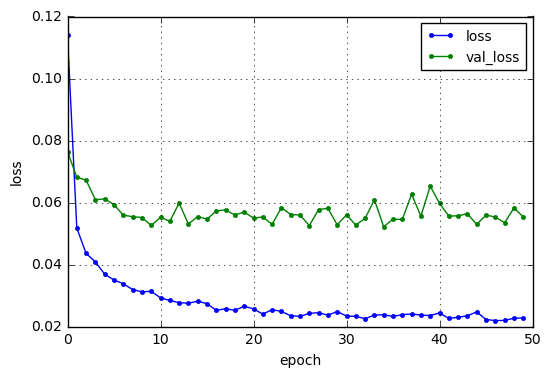

In [18]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='Adamax'
AEDimention = 128

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    print "hiden node = "+str(AEDimention)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
    '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    AutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize)

# 検証内容7

中間層の次元が小さい時，適切なスライド幅があるのか
また，次元圧縮には学習データ，つまりスライド幅が小さいほうがいいのか
検証する

固定するパラメータ
* ウィンドウ幅 [256,512,1024,2048,4096]
* スライド幅 ウィンドウ幅/64
* バッチサイズ 32
* 最適化関数　sgd
* 中間層の次元数 16

  0%|          | 784/269403 [00:00<00:34, 7833.43it/s]

AccX is registed now
Build Complete
Source shape is(1077870,)
window frames num =269404
offset=2


100%|██████████| 269403/269403 [4:17:02<00:00,  8.66it/s]


hiden node = 16
_AEdim=016_Win=0256_Sld=0004_sgd
Train on 269404 samples, validate on 269404 samples
Epoch 1/50
6s - loss: 0.0691 - val_loss: 0.0161
Epoch 2/50
6s - loss: 0.0106 - val_loss: 0.0124
Epoch 3/50
6s - loss: 0.0091 - val_loss: 0.0112
Epoch 4/50
6s - loss: 0.0086 - val_loss: 0.0107
Epoch 5/50
6s - loss: 0.0082 - val_loss: 0.0103
Epoch 6/50
6s - loss: 0.0079 - val_loss: 0.0101
Epoch 7/50
6s - loss: 0.0077 - val_loss: 0.0099
Epoch 8/50
6s - loss: 0.0075 - val_loss: 0.0098
Epoch 9/50
6s - loss: 0.0074 - val_loss: 0.0097
Epoch 10/50
6s - loss: 0.0072 - val_loss: 0.0096
Epoch 11/50
6s - loss: 0.0071 - val_loss: 0.0096
Epoch 12/50
6s - loss: 0.0070 - val_loss: 0.0095
Epoch 13/50
6s - loss: 0.0068 - val_loss: 0.0095
Epoch 14/50
6s - loss: 0.0067 - val_loss: 0.0094
Epoch 15/50
6s - loss: 0.0065 - val_loss: 0.0094
Epoch 16/50
6s - loss: 0.0064 - val_loss: 0.0093
Epoch 17/50
6s - loss: 0.0062 - val_loss: 0.0093
Epoch 18/50
6s - loss: 0.0061 - val_loss: 0.0092
Epoch 19/50
6s - loss: 0.0

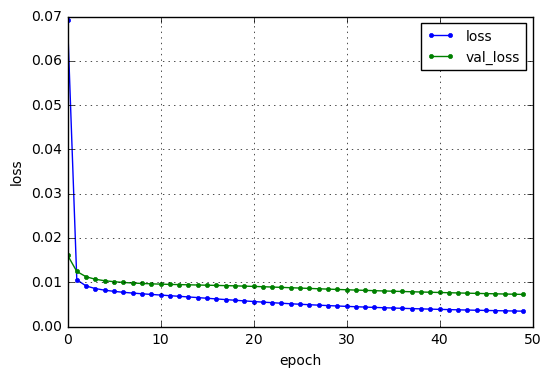

  0%|          | 642/134669 [00:00<00:20, 6410.58it/s]

AccX is registed now
Build Complete
Source shape is(1077870,)
window frames num =134670
offset=6


100%|██████████| 134669/134669 [4:42:02<00:00,  2.89it/s]


hiden node = 16
_AEdim=016_Win=0512_Sld=0008_sgd
Train on 134670 samples, validate on 134670 samples
Epoch 1/50
3s - loss: 0.1717 - val_loss: 0.0408
Epoch 2/50
3s - loss: 0.0263 - val_loss: 0.0232
Epoch 3/50
4s - loss: 0.0170 - val_loss: 0.0184
Epoch 4/50
3s - loss: 0.0141 - val_loss: 0.0162
Epoch 5/50
4s - loss: 0.0129 - val_loss: 0.0150
Epoch 6/50
3s - loss: 0.0122 - val_loss: 0.0143
Epoch 7/50
3s - loss: 0.0117 - val_loss: 0.0139
Epoch 8/50
3s - loss: 0.0114 - val_loss: 0.0135
Epoch 9/50
3s - loss: 0.0112 - val_loss: 0.0133
Epoch 10/50
3s - loss: 0.0110 - val_loss: 0.0130
Epoch 11/50
3s - loss: 0.0109 - val_loss: 0.0129
Epoch 12/50
3s - loss: 0.0107 - val_loss: 0.0127
Epoch 13/50
4s - loss: 0.0106 - val_loss: 0.0126
Epoch 14/50
3s - loss: 0.0105 - val_loss: 0.0125
Epoch 15/50
3s - loss: 0.0104 - val_loss: 0.0124
Epoch 16/50
4s - loss: 0.0103 - val_loss: 0.0124
Epoch 17/50
3s - loss: 0.0102 - val_loss: 0.0123
Epoch 18/50
3s - loss: 0.0101 - val_loss: 0.0122
Epoch 19/50
3s - loss: 0.0

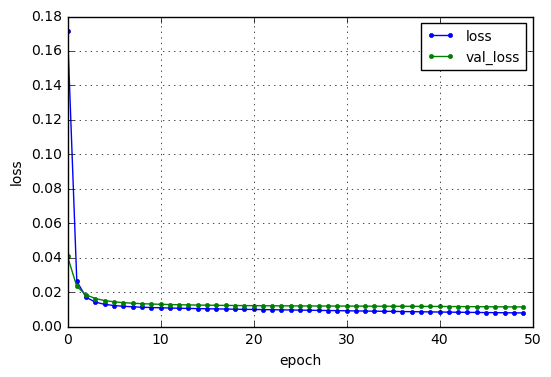

  1%|          | 504/67302 [00:00<00:13, 5035.12it/s]

AccX is registed now
Build Complete
Source shape is(1077870,)
window frames num =67303
offset=14


100%|██████████| 67302/67302 [2:27:41<00:00,  2.53it/s]


hiden node = 16
_AEdim=016_Win=1024_Sld=0016_sgd
Train on 67303 samples, validate on 67303 samples
Epoch 1/50
2s - loss: 0.3832 - val_loss: 0.2220
Epoch 2/50
2s - loss: 0.1501 - val_loss: 0.1009
Epoch 3/50
2s - loss: 0.0773 - val_loss: 0.0602
Epoch 4/50
2s - loss: 0.0498 - val_loss: 0.0435
Epoch 5/50
2s - loss: 0.0369 - val_loss: 0.0352
Epoch 6/50
2s - loss: 0.0299 - val_loss: 0.0303
Epoch 7/50
2s - loss: 0.0257 - val_loss: 0.0271
Epoch 8/50
2s - loss: 0.0230 - val_loss: 0.0248
Epoch 9/50
2s - loss: 0.0211 - val_loss: 0.0231
Epoch 10/50
2s - loss: 0.0197 - val_loss: 0.0218
Epoch 11/50
2s - loss: 0.0187 - val_loss: 0.0209
Epoch 12/50
2s - loss: 0.0179 - val_loss: 0.0201
Epoch 13/50
2s - loss: 0.0172 - val_loss: 0.0195
Epoch 14/50
2s - loss: 0.0167 - val_loss: 0.0190
Epoch 15/50
2s - loss: 0.0163 - val_loss: 0.0186
Epoch 16/50
2s - loss: 0.0160 - val_loss: 0.0182
Epoch 17/50
2s - loss: 0.0157 - val_loss: 0.0179
Epoch 18/50
2s - loss: 0.0154 - val_loss: 0.0177
Epoch 19/50
2s - loss: 0.015

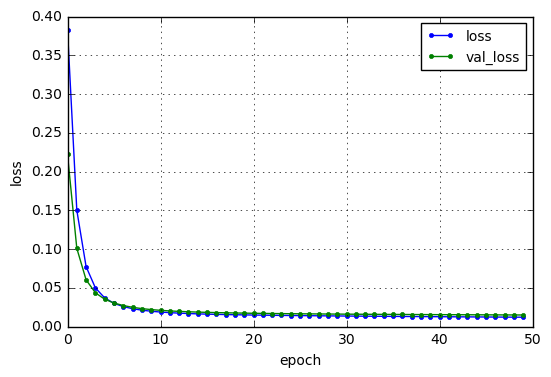

  1%|          | 301/33619 [00:00<00:11, 2994.67it/s]

AccX is registed now
Build Complete
Source shape is(1077870,)
window frames num =33620
offset=14


100%|██████████| 33619/33619 [1:20:13<00:00,  2.46it/s]


hiden node = 16
_AEdim=016_Win=2048_Sld=0032_sgd
Train on 33620 samples, validate on 33620 samples
Epoch 1/50
4s - loss: 0.5186 - val_loss: 0.4598
Epoch 2/50
4s - loss: 0.4037 - val_loss: 0.3522
Epoch 3/50
4s - loss: 0.3106 - val_loss: 0.2730
Epoch 4/50
4s - loss: 0.2430 - val_loss: 0.2158
Epoch 5/50
4s - loss: 0.1939 - val_loss: 0.1742
Epoch 6/50
4s - loss: 0.1581 - val_loss: 0.1435
Epoch 7/50
4s - loss: 0.1314 - val_loss: 0.1204
Epoch 8/50
4s - loss: 0.1113 - val_loss: 0.1029
Epoch 9/50
4s - loss: 0.0959 - val_loss: 0.0895
Epoch 10/50
4s - loss: 0.0840 - val_loss: 0.0790
Epoch 11/50
4s - loss: 0.0746 - val_loss: 0.0708
Epoch 12/50
4s - loss: 0.0672 - val_loss: 0.0642
Epoch 13/50
4s - loss: 0.0611 - val_loss: 0.0590
Epoch 14/50
4s - loss: 0.0561 - val_loss: 0.0546
Epoch 15/50
4s - loss: 0.0519 - val_loss: 0.0511
Epoch 16/50
4s - loss: 0.0484 - val_loss: 0.0481
Epoch 17/50
4s - loss: 0.0455 - val_loss: 0.0456
Epoch 18/50
4s - loss: 0.0429 - val_loss: 0.0435
Epoch 19/50
4s - loss: 0.040

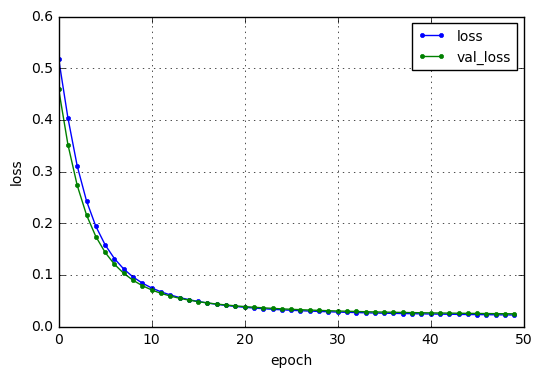

  1%|          | 179/16777 [00:00<00:09, 1783.37it/s]

AccX is registed now
Build Complete
Source shape is(1077870,)
window frames num =16778
offset=46


100%|██████████| 16777/16777 [27:14<00:00,  3.84it/s]


hiden node = 16
_AEdim=016_Win=4096_Sld=0064_sgd
Train on 16778 samples, validate on 16778 samples
Epoch 1/50
4s - loss: 0.5581 - val_loss: 0.5428
Epoch 2/50
4s - loss: 0.5257 - val_loss: 0.5087
Epoch 3/50
4s - loss: 0.4919 - val_loss: 0.4752
Epoch 4/50
4s - loss: 0.4593 - val_loss: 0.4437
Epoch 5/50
4s - loss: 0.4290 - val_loss: 0.4145
Epoch 6/50
4s - loss: 0.4010 - val_loss: 0.3877
Epoch 7/50
4s - loss: 0.3752 - val_loss: 0.3630
Epoch 8/50
4s - loss: 0.3515 - val_loss: 0.3403
Epoch 9/50
4s - loss: 0.3297 - val_loss: 0.3193
Epoch 10/50
4s - loss: 0.3096 - val_loss: 0.3001
Epoch 11/50
4s - loss: 0.2911 - val_loss: 0.2823
Epoch 12/50
4s - loss: 0.2741 - val_loss: 0.2660
Epoch 13/50
4s - loss: 0.2584 - val_loss: 0.2509
Epoch 14/50
4s - loss: 0.2439 - val_loss: 0.2371
Epoch 15/50
4s - loss: 0.2306 - val_loss: 0.2243
Epoch 16/50
4s - loss: 0.2183 - val_loss: 0.2125
Epoch 17/50
4s - loss: 0.2070 - val_loss: 0.2016
Epoch 18/50
4s - loss: 0.1965 - val_loss: 0.1915
Epoch 19/50
4s - loss: 0.186

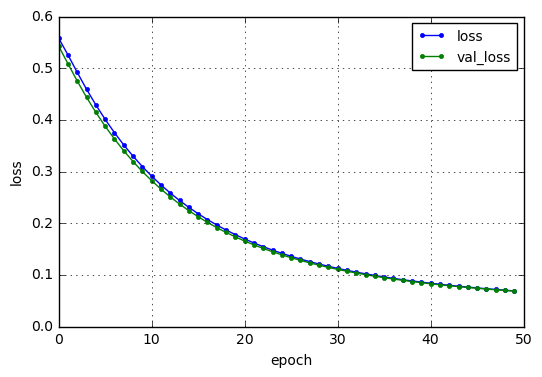

In [20]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/64
BatchSize = 32
Optim='sgd'
AEDimention = 16

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    print "hiden node = "+str(AEDimention)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
    '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    AutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize)